In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True).set_index('id')
profile = pd.read_json('data/profile.json', orient='records', lines=True).set_index('id')
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# analyze profile table
print(profile.describe())
print(profile.gender.value_counts())
print(profile.isna().sum())
profile.became_member_on = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")

                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000
M    8484
F    6129
O     212
Name: gender, dtype: int64
gender              2175
age                    0
became_member_on       0
income              2175
dtype: int64


In [4]:
# there is missing data, is it all in the same rows
print("Profile Unidentified Length")
unidentified = profile[profile.age > 102].copy()
print(unidentified.shape[0])
print(profile.shape[0])
print("Missing Percent: " + str(round(unidentified.shape[0]/profile.shape[0] * 100, 2)))

Profile Unidentified Length
2175
17000
Missing Percent: 12.79


In [5]:
# verify that people with valid age have other fields as valid
identified = profile[profile.age <= 102]
identified.isna().sum()

gender              0
age                 0
became_member_on    0
income              0
dtype: int64

#### Plot "profile" distributions

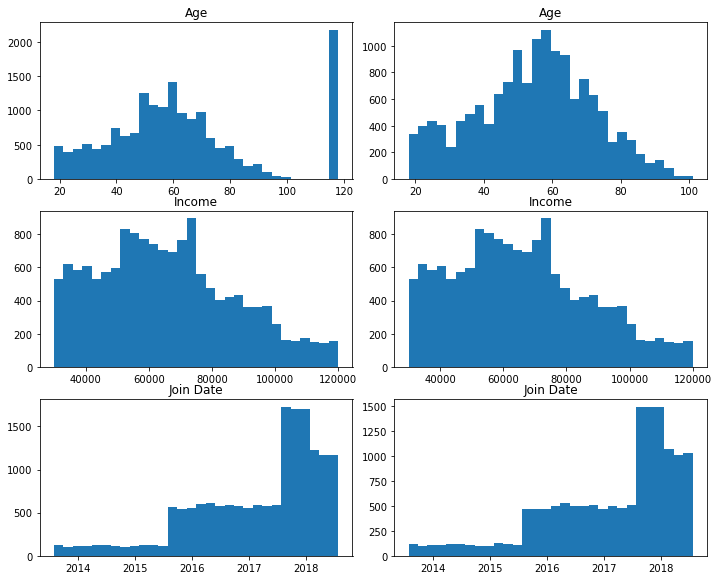

In [6]:
fig, ax = plt.subplots(3,2, figsize=(10,8))
fig.tight_layout()
ax[0, 0].hist(profile.age, bins=30)
ax[0, 0].set_title("Age")
ax[1, 0].hist(profile.income, bins=30)
ax[1, 0].set_title("Income")
ax[2, 0].hist(profile.became_member_on, bins=30)
ax[2, 0].set_title("Join Date")
years_fmt = mdates.DateFormatter('%Y')
ax[2, 0].xaxis.set_major_formatter(years_fmt)

ax[0, 1].hist(identified.age, bins=30)
ax[0, 1].set_title("Age")
ax[1, 1].hist(identified.income, bins=30)
ax[1, 1].set_title("Income")
ax[2, 1].hist(identified.became_member_on, bins=30)
ax[2, 1].set_title("Join Date")
ax[2, 1].xaxis.set_major_formatter(years_fmt)
plt.savefig("images/profile_hist.png")

In [7]:
profile = profile.join(pd.get_dummies(profile.gender), how='inner')
profile.drop('gender', axis=1, inplace=True)

In [8]:
profile.became_member_on = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
identified = profile[profile.age <= 102]
profile.head(2)

,age,became_member_on,income,F,M,O
id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,2017-02-12,NaN,0,0,0
0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,112000.0,1,0,0


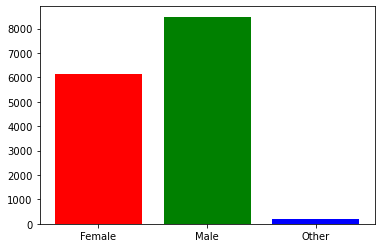

In [10]:
fig, ax = plt.subplots()
ax.bar(['Female', 'Male', 'Other'], identified[['F', 'M', 'O']].sum(), color=['red', 'green', 'blue'])
plt.savefig("images/gender_distribution.png")

In [11]:
print(portfolio.describe())
portfolio.head(2)

          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


,reward,channels,difficulty,duration,offer_type
id,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo


Lets break channels out into one-hot vectors

In [12]:
email = {}
mobile = {}
social = {}
web = {}
for index, row in portfolio.iterrows():
    if 'email' in row['channels']:
        email[index] = 1
    else:
        email[index] = 0
        
    if 'mobile' in row['channels']:
        mobile[index] = 1
    else:
        mobile[index] = 0
        
    if 'social' in row['channels']:
        social[index] = 1
    else:
        social[index] = 0
    
    if 'web' in row['channels']:
        web[index] = 1
    else:
        web[index] = 0

email = pd.Series(email)
email.name = 'email'
mobile = pd.Series(mobile)
mobile.name = 'mobile'
social = pd.Series(social)
social.name = 'social'
web = pd.Series(web)
web.name = 'web'

portfolio = pd.concat([portfolio, email, mobile, social, web], axis=1)

In [13]:
portfolio.drop('channels', axis=1, inplace=True)
portfolio.head(2)

,reward,difficulty,duration,offer_type,email,mobile,social,web
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1


We have 10 different kinds of offers


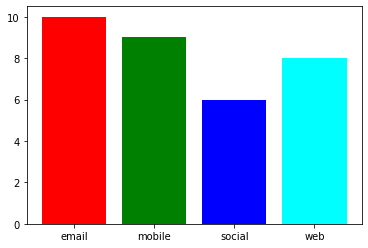

In [14]:
print(f'We have {portfolio.shape[0]} different kinds of offers')
fig, ax = plt.subplots()
names = ['email', 'mobile', 'social', 'web']
ax.bar(names, portfolio[names].sum(), color=['red', 'green', 'blue', 'cyan'])
plt.savefig("images/promotion_channels.png")

#### Plot the "portfolio" data distributions

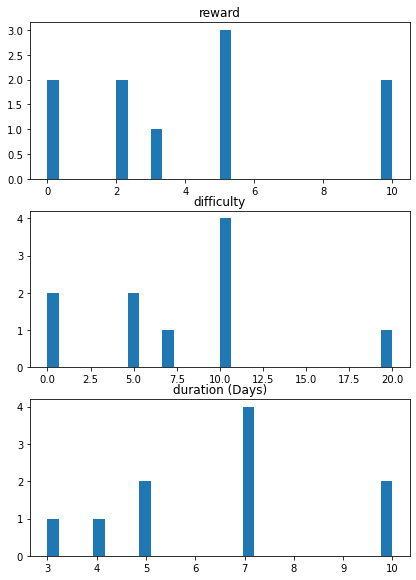

In [15]:
fig, ax = plt.subplots(3, figsize=(6,8))
fig.tight_layout()
ax[0].hist(portfolio.reward, bins=30)
ax[0].set_title("reward")
ax[1].hist(portfolio.difficulty, bins=30)
ax[1].set_title("difficulty")
ax[2].hist(portfolio.duration, bins=30)
ax[2].set_title("duration (Days)")
plt.savefig("images/promotion_hist.png")

In [16]:
print(transcript.describe())
print(transcript.event.value_counts())

                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


In [17]:
# modify trascript to include when transactions were in an offer period had been viewed
# this value will indicate wether the transaction in question happened due to a running offer.
def transaction_state(df, impression_colname, impression_source_colname):
    """ input
      df: transcript dataframe, has information on when users transacted and when they received offers
      colname: name of new column that will have impression - transaction or not and if so is it because of offer   
    """
    
    customer_ids = set(df.person.values)
    impression = {}
    source = {}
    # iterate over all customers
    for customer in customer_ids:
        customer_transcript = df[df.person == customer]

        received_offer = {}
        active_dict = {}
        max_active_end = 0 # the end time of the event that is ending the latest
        cur_max_offer_id = "" # id of the offer with max active end
        for index, row in customer_transcript.iterrows():
            time = row['time']
            # eliminate adverts not active from active_dict
            for key in list(active_dict.keys()):
                if active_dict[key] < time:
                    del active_dict[key]
            
            # if new offer, record when it will expire in received_offer
            if row['event'] == "offer received":
                new_event_end = row['time'] + portfolio.loc[
                    row['value']['offer id'] == portfolio.index]['duration'].values[0] * 24
                received_offer[row['value']['offer id']] = new_event_end
            
            # after viewing an offer we add it to the active_dict and possibly update the time until all transactions
            # will be flagged as being due to an offer
            if row['event'] == "offer viewed":
                # error in data if element not in dict (viewed an offer that hasn't been received)
                new_event_end = received_offer[row['value']['offer id']]
                active_dict[row['value']['offer id']] = new_event_end
                if new_event_end > max_active_end:
                    max_active_end = new_event_end
                    cur_max_offer_id = row['value']['offer id']
                    
            if row['event'] == 'offer completed':
                offer_id = row['value']['offer_id']
                # an unviewed offer could be completed
                active_dict.pop(offer_id, None)
                if offer_id == cur_max_offer_id:
                    # find next offer with highest end date
                    new_max_active_end = 0
                    new_max_offer_id = ""
                    for key, value in active_dict.items():
                        if value > new_max_active_end:
                            new_max_active_end = value
                            new_max_offer_id = key
                    max_active_end = new_max_active_end
                    new_max_offer_id = new_max_offer_id

            # assign values in new col dict
            if row['event'] == 'transaction':
                if time <= max_active_end:
                    impression[index] = 1
                else:
                    impression[index] = 0
                this_source = []
                for key, value in active_dict.items():
                    this_source.append(key)
                source[index] = this_source
            else:
                impression[index] = -1
                source[index] = []
    df = df.copy()
    df[impression_colname] = pd.Series(impression)
    df[impression_source_colname] = pd.Series(source)
    return df

In [18]:
impressions_df = transaction_state(transcript, 'because_of_offer', 'impression_source')

In [19]:
# test the transaction state method. 

test1 = transcript.loc[transcript.person == "78afa995795e4d85b5d9ceeca43f5fef"]
test1_return = transaction_state(test1, 'because_of_offer', 'impression_source')
test1_expected = {0: -1, 15561: -1, 47582: 1, 47583: -1, 49502: 0, 53176: -1, 85291: -1, 87134: 1, 
                 92104: 1, 141566: 0, 150598: -1, 163375: -1, 201572: -1, 218393: 1, 218394: -1, 
                 218395: -1, 230412: 0, 262138: -1}
test1_expected_source = {0: [], 15561: [], 47582: ['9b98b8c7a33c4b65b9aebfe6a799e6d9'], 47583: [], 49502: [],
                         53176: [], 85291: [], 87134: ['5a8bc65990b245e5a138643cd4eb9837'],  
                         92104: ['5a8bc65990b245e5a138643cd4eb9837'], 141566: [], 150598: [], 163375: [], 
                         201572: [], 218393: ['ae264e3637204a6fb9bb56bc8210ddfd'], 218394: [], 218395: [], 
                         230412: [], 262138: []}

assert((test1_return.because_of_offer == pd.Series(test1_expected)).all())
assert((test1_return.impression_source == pd.Series(test1_expected_source)).all())

test2 =  transcript.loc[transcript.person == "2e87ba0fba1a4d1a8614af771f07a94d"]
test2_return = transaction_state(test2, 'because_of_offer', 'impression_source')
test2_expected = {45: -1, 24223: -1, 31109: 1, 31110: -1, 42034: 0, 53222: -1, 65856: -1, 65857: 1, 
                 65858: -1, 74812: 0, 106958: 0, 110873: -1, 123553: -1, 135232: 1, 135233: -1, 
                 143579: 0, 150644: -1, 163387: -1, 174370: 1, 174371: -1, 187146: 0, 201615: -1,
                 221912: -1, 232884: 1, 235177: 1, 300661: 0}
assert((test2_return.because_of_offer == pd.Series(test2_expected)).all())
print("tests passed")

tests passed


In [20]:
impressions_df.to_csv("data/impressions.csv")
identified.to_csv("data/identified.csv")
impressions_df.tail()

,person,event,value,time,because_of_offer,impression_source
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,0,[]
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,0,[]
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,0,[]
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,1,[9b98b8c7a33c4b65b9aebfe6a799e6d9]
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,0,[]


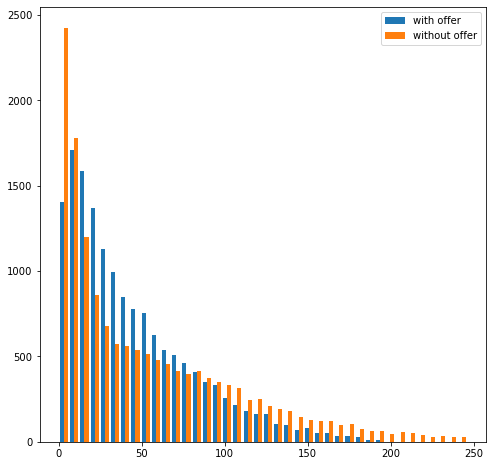

In [23]:
# see distribution of transactions overall when in offer and when not in offer
transactions_df = impressions_df.loc[impressions_df['because_of_offer'] > -1].copy()
transactions_df['value'] = transactions_df['value'].apply(lambda x: x['amount'])

without_offer = transactions_df[transactions_df.because_of_offer == 0]
with_offer = transactions_df[transactions_df.because_of_offer == 1]

without_offer_sum = without_offer.groupby('person').sum(1)
with_offer_sum = with_offer.groupby('person').sum(1)

with_offer_sum = with_offer_sum[stats.zscore(with_offer_sum.value) < 2]
without_offer_sum = without_offer_sum[stats.zscore(without_offer_sum.value) < 2]

fig, ax = plt.subplots(figsize=(8,8))
ax.hist([with_offer_sum.value.values, without_offer_sum.value.values], bins=40, 
        label=['with offer', 'without offer'])
ax.legend()
plt.savefig("images/revenue_diff.png")

As we would hope, it seems in general the availibility of offer does cause more revenue

In [1]:
def frequency_interaction(df, promotions_ids):
    """ Get an encoding of individual and promotoins based on wether
    the given individual saw/received the given promotion
    
    Input:
    df: The transcript table
    promotoin_ids: An array containing id of all promotions - as given in the transcript table
    """
    customer_ids = set(df.person.values)
    viewed = {}
    received = {}
    raw_dict = {promo_id: 0 for promo_id in promotions_ids}
    # iterate over all customers
    for customer in customer_ids:
        customer_transcript = df[df.person == customer]
        
        person_dict_receive = raw_dict.copy()
        person_dict_view = raw_dict.copy()
        for index, row in customer_transcript.iterrows():
            
            if row['event'] == "offer received":
                person_dict_receive[row['value']['offer id']] += 1
            
            if row['event'] == "offer viewed":
                person_dict_view[row['value']['offer id']] += 1
    
        viewed[customer] = person_dict_view
        received[customer] = person_dict_receive
        
    return pd.DataFrame(viewed), pd.DataFrame(received)

In [25]:
test1 = transcript.loc[transcript.person == "78afa995795e4d85b5d9ceeca43f5fef"]
expected_receive1 = {'ae264e3637204a6fb9bb56bc8210ddfd': 1, '4d5c57ea9a6940dd891ad53e9dbe8da0': 0,
                     '3f207df678b143eea3cee63160fa8bed': 0, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 1, 
                     '0b1e1539f2cc45b7b9fa7c272da2e1d7': 0, '2298d6c36e964ae4a3e7e9706d1fb8c2': 0,
                     'fafdcd668e3743c1bb461111dcafc2a4': 0, '5a8bc65990b245e5a138643cd4eb9837': 1,
                     'f19421c1d4aa40978ebb69ca19b0e20d': 1, '2906b810c7d4411798c6938adc9daaa5': 0}

expected_view1 =    {'ae264e3637204a6fb9bb56bc8210ddfd': 1, '4d5c57ea9a6940dd891ad53e9dbe8da0': 0,
                     '3f207df678b143eea3cee63160fa8bed': 0, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 1, 
                     '0b1e1539f2cc45b7b9fa7c272da2e1d7': 0, '2298d6c36e964ae4a3e7e9706d1fb8c2': 0,
                     'fafdcd668e3743c1bb461111dcafc2a4': 0, '5a8bc65990b245e5a138643cd4eb9837': 1,
                     'f19421c1d4aa40978ebb69ca19b0e20d': 1, '2906b810c7d4411798c6938adc9daaa5': 0}
view1, receive1 = frequency_interaction(test1, portfolio.index)
assert(view1.to_dict()['78afa995795e4d85b5d9ceeca43f5fef'] == expected_view1)
assert(receive1.to_dict()['78afa995795e4d85b5d9ceeca43f5fef'] == expected_receive1)
print('test passed')

test passed


In [2]:
# determine if a given promotion influenced a certain individual
impressions_df_pos = impressions_df[impressions_df.because_of_offer == 1]
influenced = {}
customer_ids = set(impressions_df_pos.person.values)
raw_dict = {promo_id: 0 for promo_id in portfolio.index}
# iterate over all customers
for customer in customer_ids:
    customer_impression = impressions_df_pos[impressions_df_pos.person == customer]
        
    impression = raw_dict.copy()
    for index, row in customer_impression.iterrows():
        for promo_id in row['impression_source']:
            impression[promo_id] = 1
    influenced[customer] = impression

influenced_df = pd.DataFrame(influenced)

NameError: name 'impressions_df' is not defined

In [28]:
viewed_df, received_df = frequency_interaction(transcript, portfolio.index)

### Investigate Relationships
Lets see if distributions of influence, and receiving of promotions changes on characteristics of the individual/promotion

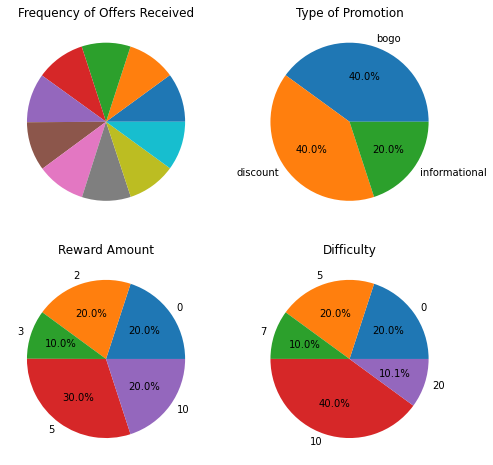

In [30]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
received_df = received_df.T
received_counts = received_df.sum()
received_counts.name = 'received_counts'
received_total = pd.concat([portfolio, received_counts], axis=1)

_ = ax[0, 0].pie(received_total.received_counts)
_ = ax[0, 0].set_title("Frequency of Offers Received")
offer_type = received_total.groupby('offer_type').sum()
_ = ax[0, 1].pie(offer_type.received_counts, labels=offer_type.index, autopct='%1.1f%%')
_ = ax[0, 1].set_title("Type of Promotion")
reward = received_total.groupby('reward').sum()
_ = ax[1, 0].pie(reward.received_counts, labels=reward.index, autopct='%1.1f%%')
_ = ax[1, 0].set_title("Reward Amount")
difficulty = received_total.groupby('difficulty').sum()
_ = ax[1, 1].pie(difficulty.received_counts, labels=difficulty.index, autopct='%1.1f%%')
_ = ax[1, 1].set_title("Difficulty")
plt.savefig('images/general_promotion_pi.png')

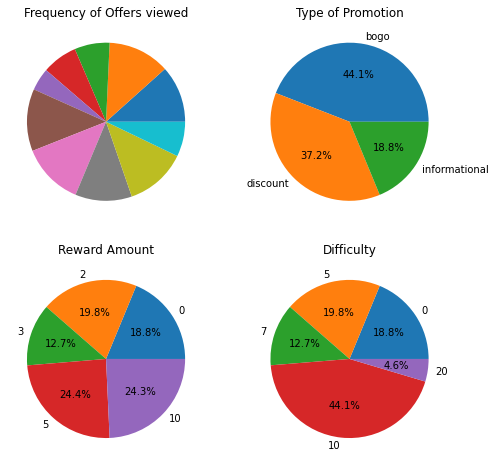

In [31]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
viewed_df = viewed_df.T
viewed_counts = viewed_df.sum()
viewed_counts.name = 'viewed_counts'
viewed_total = pd.concat([portfolio, viewed_counts], axis=1)

_ = ax[0, 0].pie(viewed_total.viewed_counts)
_ = ax[0, 0].set_title("Frequency of Offers viewed")
offer_type = viewed_total.groupby('offer_type').sum()
_ = ax[0, 1].pie(offer_type.viewed_counts, labels=offer_type.index, autopct='%1.1f%%')
_ = ax[0, 1].set_title("Type of Promotion")
reward = viewed_total.groupby('reward').sum()
_ = ax[1, 0].pie(reward.viewed_counts, labels=reward.index, autopct='%1.1f%%')
_ = ax[1, 0].set_title("Reward Amount")
difficulty = viewed_total.groupby('difficulty').sum()
_ = ax[1, 1].pie(difficulty.viewed_counts, labels=difficulty.index, autopct='%1.1f%%')
_ = ax[1, 1].set_title("Difficulty")
plt.savefig('images/viewed_promotion_pi.png')

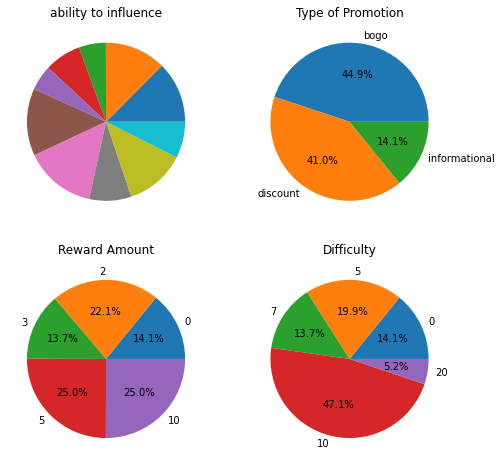

In [40]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
influenced_df = influenced_df.T
influenced_counts = influenced_df.sum()
influenced_counts.name = 'influence_counts'
influenced_total = pd.concat([portfolio, influenced_counts], axis=1)

_ = ax[0, 0].pie(influenced_total.influence_counts)
_ = ax[0, 0].set_title("ability to influence")
offer_type = influenced_total.groupby('offer_type').sum()
_ = ax[0, 1].pie(offer_type.influence_counts, labels=offer_type.index, autopct='%1.1f%%')
_ = ax[0, 1].set_title("Type of Promotion")
reward = influenced_total.groupby('reward').sum()
_ = ax[1, 0].pie(reward.influence_counts, labels=reward.index, autopct='%1.1f%%')
_ = ax[1, 0].set_title("Reward Amount")
difficulty = influenced_total.groupby('difficulty').sum()
_ = ax[1, 1].pie(difficulty.influence_counts, labels=difficulty.index, autopct='%1.1f%%')
_ = ax[1, 1].set_title("Difficulty")
plt.savefig('images/influenced_promotion_pi.png')

In [42]:
# lets try combining influence with person data
influenced_df_summed = pd.DataFrame(influenced_df.sum(axis=1), columns=['influence_count'])
influence_person = influenced_df_summed.join(identified, how='inner')
influence_person.head(2)

,influence_count,age,became_member_on,income,F,M,O
8d96c3ad478243dc85d2767d65458372,2,44,2018-01-10,48000.0,0,1,0
50e273dc67134760b08bfe7e933099c0,3,30,2016-05-20,56000.0,1,0,0


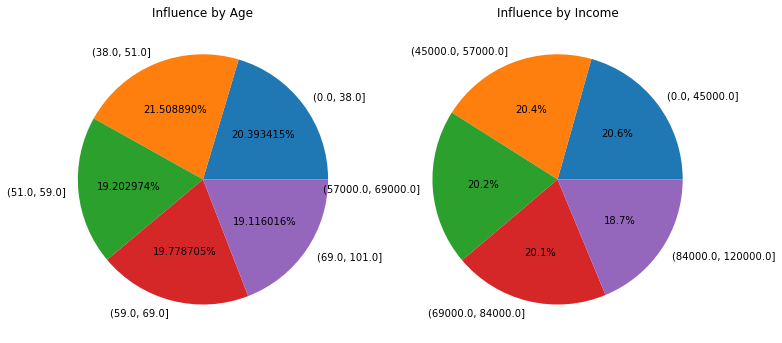

In [46]:
# lets bucket by index
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout()
age_quantiles = list(np.quantile(influence_person.age, [0.2, 0.4, 0.6, 0.8, 1]))
influence_person['age_categ'] = pd.cut(influence_person.age, bins=([0] + age_quantiles))
age_categ = influence_person.groupby('age_categ').sum()
_ = ax[0].pie(age_categ.influence_count, labels=age_categ.index, autopct='%1f%%')
_ = ax[0].set_title("Influence by Age")

income_quantiles = list(np.quantile(influence_person.income, [0.2, 0.4, 0.6, 0.8, 1]))
influence_person['income_categ'] = pd.cut(influence_person.income, bins=([0] + income_quantiles))
income_categ = influence_person.groupby('income_categ').sum()
_ = ax[1].pie(income_categ.influence_count, labels=income_categ.index, autopct='%1.1f%%')
_ = ax[1].set_title("Influence by Income")
plt.savefig("images/profile_pi.png")

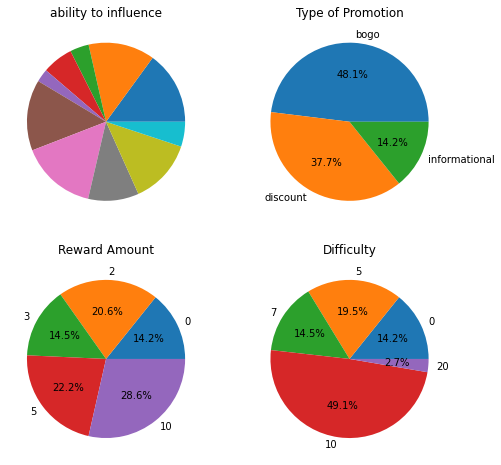

In [51]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
low_income_df = influenced_df[influenced_df.index.isin(list(identified.loc[identified.income < 40000].id))]
influenced_counts = low_income_df.sum()
influenced_counts.name = 'influence_counts'
influenced_total = pd.concat([portfolio, influenced_counts], axis=1)

_ = ax[0, 0].pie(influenced_total.influence_counts)
_ = ax[0, 0].set_title("ability to influence")
offer_type = influenced_total.groupby('offer_type').sum()
_ = ax[0, 1].pie(offer_type.influence_counts, labels=offer_type.index, autopct='%1.1f%%')
_ = ax[0, 1].set_title("Type of Promotion")
reward = influenced_total.groupby('reward').sum()
_ = ax[1, 0].pie(reward.influence_counts, labels=reward.index, autopct='%1.1f%%')
_ = ax[1, 0].set_title("Reward Amount")
difficulty = influenced_total.groupby('difficulty').sum()
_ = ax[1, 1].pie(difficulty.influence_counts, labels=difficulty.index, autopct='%1.1f%%')
_ = ax[1, 1].set_title("Difficulty")
plt.savefig("images/low_income_pi.png")

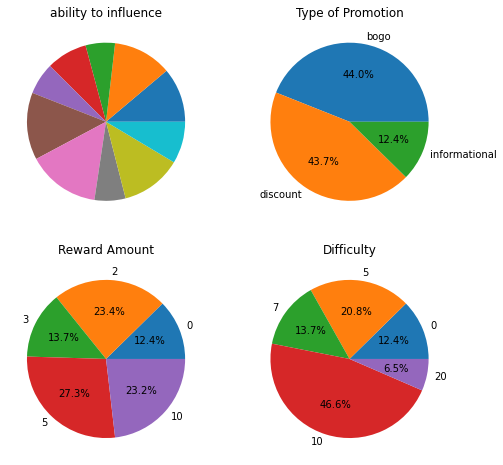

In [52]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
high_income_df = influenced_df[influenced_df.index.isin(list(identified.loc[identified.income > 80000].id))]
influenced_counts = high_income_df.sum()
influenced_counts.name = 'influence_counts'
influenced_total = pd.concat([portfolio, influenced_counts], axis=1)

_ = ax[0, 0].pie(influenced_total.influence_counts)
_ = ax[0, 0].set_title("ability to influence")
offer_type = influenced_total.groupby('offer_type').sum()
_ = ax[0, 1].pie(offer_type.influence_counts, labels=offer_type.index, autopct='%1.1f%%')
_ = ax[0, 1].set_title("Type of Promotion")
reward = influenced_total.groupby('reward').sum()
_ = ax[1, 0].pie(reward.influence_counts, labels=reward.index, autopct='%1.1f%%')
_ = ax[1, 0].set_title("Reward Amount")
difficulty = influenced_total.groupby('difficulty').sum()
_ = ax[1, 1].pie(difficulty.influence_counts, labels=difficulty.index, autopct='%1.1f%%')
_ = ax[1, 1].set_title("Difficulty")
plt.savefig("images/high_income_pi.png")

In [220]:
# save any files for future use

impressions_df.to_csv("data/impressions.csv")
identified.to_csv("data/identified.csv")
viewed_df.to_csv("data/viewed.csv")
received_df.to_csv("data/received.csv")
influenced_df.to_csv("data/influenced.csv")
portfolio.to_csv("data/updated_portfolio.csv")